In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install numpy
# %pip install matplotlib
# %pip install nbformat
# %pip install opencv-python
# %pip install tensorflow
# %pip install wandb
# %pip install imblearn
# %pip install seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

import wandb
%env "WANDB_NOTEBOOK_NAME" "model_data_augmentation_mobilenetv2.ipynb"

wandb.login()

from wandb.integration.keras import WandbMetricsLogger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="model_data_augmentation_mobilenetv2.ipynb"


wandb: Currently logged in as: pedro-mariani (dspro2-group9). Use `wandb login --relogin` to force relogin


In [3]:
label_df = pd.read_csv(
    "../../../data/processed/combined/combined_label.csv", index_col=False
)
data_dir = "../../../data/processed/combined/img/"

label_df.head()

,image_name,expression_label
0,angry_0.jpg,angry
1,angry_1.jpg,angry
2,fear_2.jpg,fear
3,angry_4.jpg,angry
4,angry_5.jpg,angry


In [4]:
def load_data(dir_path, img_size):
    X = []
    y = []

    for index, row in label_df.iterrows():
        image_path = os.path.join(dir_path, row["image_name"])
        img = cv2.imread(image_path)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype("float32")           
        
        X.append(img)
        y.append(row["expression_label"])

    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
IMG_SIZE = (96, 96)

X, y = load_data(data_dir, IMG_SIZE)

In [6]:
dummies = pd.get_dummies(label_df["expression_label"])
dummies.head()

,angry,disgust,fear,happy,neutral,sad,surprise
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [7]:
y = dummies.values
y

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [8]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio)
)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(53676, 96, 96, 3)
(6710, 96, 96, 3)
(6710, 96, 96, 3)
(53676, 7)
(6710, 7)
(6710, 7)


# Distribution of classes in each set


In [9]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
class_count_in_train_set = np.sum(y_train, axis=0)

fig = px.bar(x=labels, y=class_count_in_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [10]:
class_count_in_validation_set = np.sum(y_valid, axis=0)
fig = px.bar(x=labels, y=class_count_in_validation_set, color=labels)

fig.update_layout(
    title="Distribution of each label in validation set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [11]:
class_count_in_test_set = np.sum(y_test, axis=0)
fig = px.bar(x=labels, y=class_count_in_test_set, color=labels)

fig.update_layout(
    title="Distribution of each label in test set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Oversampling with SMOTE

In [12]:
# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_train_reshaped = X_train.reshape(n_samples, n_channels * height * width)

In [13]:
# initialize the SMOTE model
smote = SMOTE(random_state=62)

# perform re-sampling on modified X given y
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)
X_train_smote = X_train_smote.reshape(len(X_train_smote), 96, 96, 3)


Exception in thread Thread-11 (_readerthread):
Traceback (most recent call last):
  File "C:\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\pedro\Documents\Studium\Workspaces\Python\DSPRO2\Emotion_Recognition\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Python311\Lib\subprocess.py", line 1568, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>
c:\Users\pedro\Documents\Studium\Workspaces\Python\DSPRO2\Emotion_Recognition\.venv\Lib\site-packages\job

In [14]:
class_count_in_train_smote_set = np.sum(y_train_smote, axis=0)
fig = px.bar(x=labels, y=class_count_in_train_smote_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set after SMOTE",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Model training with data augmentation


In [15]:
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

In [16]:
NUM_CLASSES = 7

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [17]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",
    name="mobileNetV2_with_data_augmentation_epoch10_40_batch128",
    # track hyperparameters and run metadata with wandb.config
    config={
        "architecture": "MobileNetV2",
        "optimizer": "Adam(learning_rate=3e-4)",
        "loss": "categorical_crossentropy",
        "metric": ["categorical_accuracy"],        
        "epoch_frozen": 10,
        "epoch_unfrozen": 40,
        "batch_size": 128,
        "IMG_SIZE": "96, 96",        
        "Dense_1": 512,
        "Dense_1_activation": "relu",
        "Dropout": 0.4,
        "Dense_2": 7,
        "Dense_2_activation" : "softmax"
    }
)

config = wandb.config


In [18]:
# augment and rescale for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    rescale=1.0 / 255.0,
)

# only rescale for validation and test set
test_val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


# get batch iterator for training
train_iterator = train_datagen.flow(
    X_train_smote, y_train_smote, batch_size=config["batch_size"]
)
# get batch iterator for validation
val_iterator = test_val_datagen.flow(X_valid, y_valid, batch_size=config["batch_size"])

# get batch iterator for test (use only once for evaluation)
test_iterator = test_val_datagen.flow(X_test, y_test, batch_size=config["batch_size"])

In [19]:
model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=3e-4),
    metrics=config["metric"],
)

history = model.fit(
    train_iterator, 
    validation_data=val_iterator,
    epochs=config["epoch_frozen"],    
    callbacks=[WandbMetricsLogger(log_freq=5)],
)                     

Epoch 1/10


c:\Users\pedro\Documents\Studium\Workspaces\Python\DSPRO2\Emotion_Recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

wandb: ERROR Unable to log learning rate.


548/548 ━━━━━━━━━━━━━━━━━━━━ 253s 453ms/step - categorical_accuracy: 0.2746 - loss: 2.0290 - val_categorical_accuracy: 0.3542 - val_loss: 1.6996
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 457ms/step - categorical_accuracy: 0.3393 - loss: 1.6899 - val_categorical_accuracy: 0.3724 - val_loss: 1.6348
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 457ms/step - categorical_accuracy: 0.3644 - loss: 1.6413 - val_categorical_accuracy: 0.3948 - val_loss: 1.5960
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 457ms/step - categorical_accuracy: 0.3713 - loss: 1.6222 - val_categorical_accuracy: 0.3736 - val_loss: 1.6223
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 253s 460ms/step - categorical_accuracy: 0.3809 - loss: 1.6032 - val_categorical_accuracy: 0.4046 - val_loss: 1.5750
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 458ms/step - categorical_accuracy: 0.3866 - loss: 1.5915 - val_categorical_accuracy: 0.3951 - val_loss: 1.5816
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 252s 458ms/step - categorical_accur

In [20]:
base_model.trainable = True

model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=3e-4),
    metrics=config["metric"],
)

history = model.fit(
    train_iterator, 
    validation_data=val_iterator,
    epochs=config["epoch_unfrozen"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

wandb.finish()

Epoch 1/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 812s 1s/step - categorical_accuracy: 0.3526 - loss: 1.6736 - val_categorical_accuracy: 0.3617 - val_loss: 1.8457
Epoch 2/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - categorical_accuracy: 0.4850 - loss: 1.3731 - val_categorical_accuracy: 0.4036 - val_loss: 1.5520
Epoch 3/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - categorical_accuracy: 0.5302 - loss: 1.2600 - val_categorical_accuracy: 0.4629 - val_loss: 1.4905
Epoch 4/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - categorical_accuracy: 0.5565 - loss: 1.1939 - val_categorical_accuracy: 0.3304 - val_loss: 2.3106
Epoch 5/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 784s 1s/step - categorical_accuracy: 0.5783 - loss: 1.1423 - val_categorical_accuracy: 0.4382 - val_loss: 1.6200
Epoch 6/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 758s 1s/step - categorical_accuracy: 0.5925 - loss: 1.1068 - val_categorical_accuracy: 0.4945 - val_loss: 1.4200
Epoch 7/40
548/548 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - categorical_accuracy: 0.604

batch/batch_step,▁▁▁▂▂▂▂▃▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/categorical_accuracy,▁▂▂▂▂▂▂▂▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████
batch/loss,█▇▇▇▇▇▇▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
epoch/categorical_accuracy,▁▂▂▂▂▂▂▂▂▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
epoch/loss,█▇▇▇▇▇▇▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▂▂▃▂▃▃▃▃▂▃▅▁▆▇█▇▇▇█████▅▆▇▆▆▇▇▇▇██▇████▇
epoch/val_loss,▃▃▃▃▃▃▂▃▅▂▂█▁▃▁▂▁▁▂▁▃▂▂▇▃▃▅▅▆▆▅▃▅▄▅▅▅▆▇█
batch/batch_step,21995
batch/categorical_accuracy,0.87429
batch/loss,0.34921


In [21]:
model.save("../../../model/240605_mobilenetv2_augmentation_model.keras")

# Confusion matrix with validation set

In [22]:
X_valid_normalized = X_valid / 255

y_pred = model.predict(X_valid_normalized)
true_class = tf.argmax(y_valid, 1)
predicted_class = tf.argmax(y_pred, 1)

210/210 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step


[Text(0, 0.5, 'angry'),
 Text(0, 1.5, 'disgust'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'happy'),
 Text(0, 4.5, 'neutral'),
 Text(0, 5.5, 'sad'),
 Text(0, 6.5, 'surprise')]

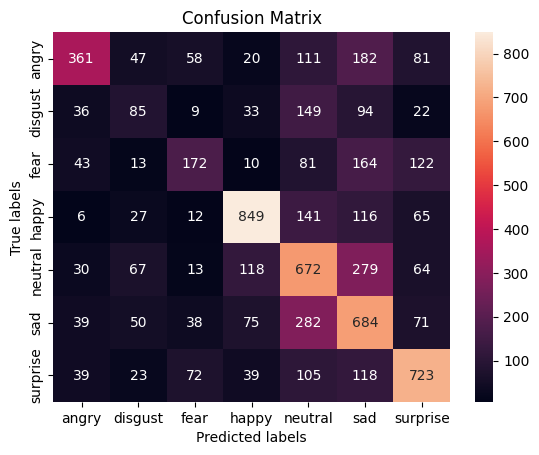

In [23]:
cm = confusion_matrix(true_class, predicted_class)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)

# labels, title and ticks

ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

ax.xaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)

ax.yaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)